# Testing the Omero Python API with Stardist

### References
https://docs.openmicroscopy.org/omero/5.6.0/developers/Python.html


https://arxiv.org/pdf/1908.03636.pdf

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
from csbdeep.utils import Path, normalize
from stardist import random_label_cmap
from stardist.models import StarDist2D, StarDist3D

from widgets import OMEConnect
from roi_utils import get_rois_as_labels, register_shape_to_roi

from skimage.measure import find_contours

Using TensorFlow backend.


In [2]:
m = OMEConnect()

display(m)

OMEConnect(children=(Text(value='', description='OME loggin'), Password(description='OME password'), Button(de…

ConnectionLostException: Ice.ConnectionLostException:
recv() returned zero

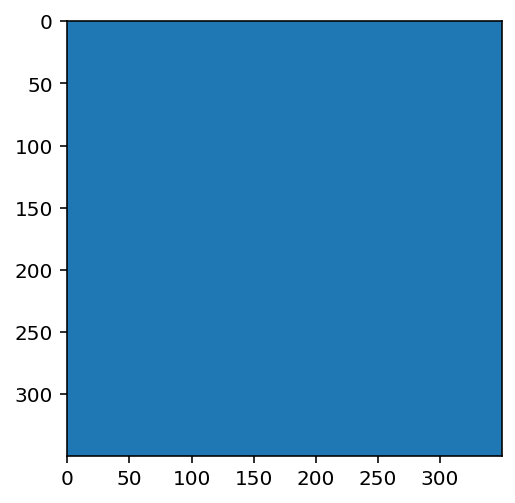

In [3]:
conn = m.conn

image = conn.getObject("Image", 2)
imshape = (image.getSizeX(), image.getSizeY())

labels = get_rois_as_labels(image, conn)



_ = plt.imshow(labels[250:600, 450:800], cmap="tab20")



In [4]:
model = StarDist2D(None, name='2D_demo', basedir='../../stardist/models/examples')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


Channels: 
0: 	 HOECHST 33342
1: 	 Alexa 488
2: 	 Alexa 568
Number of Z-planes: 70



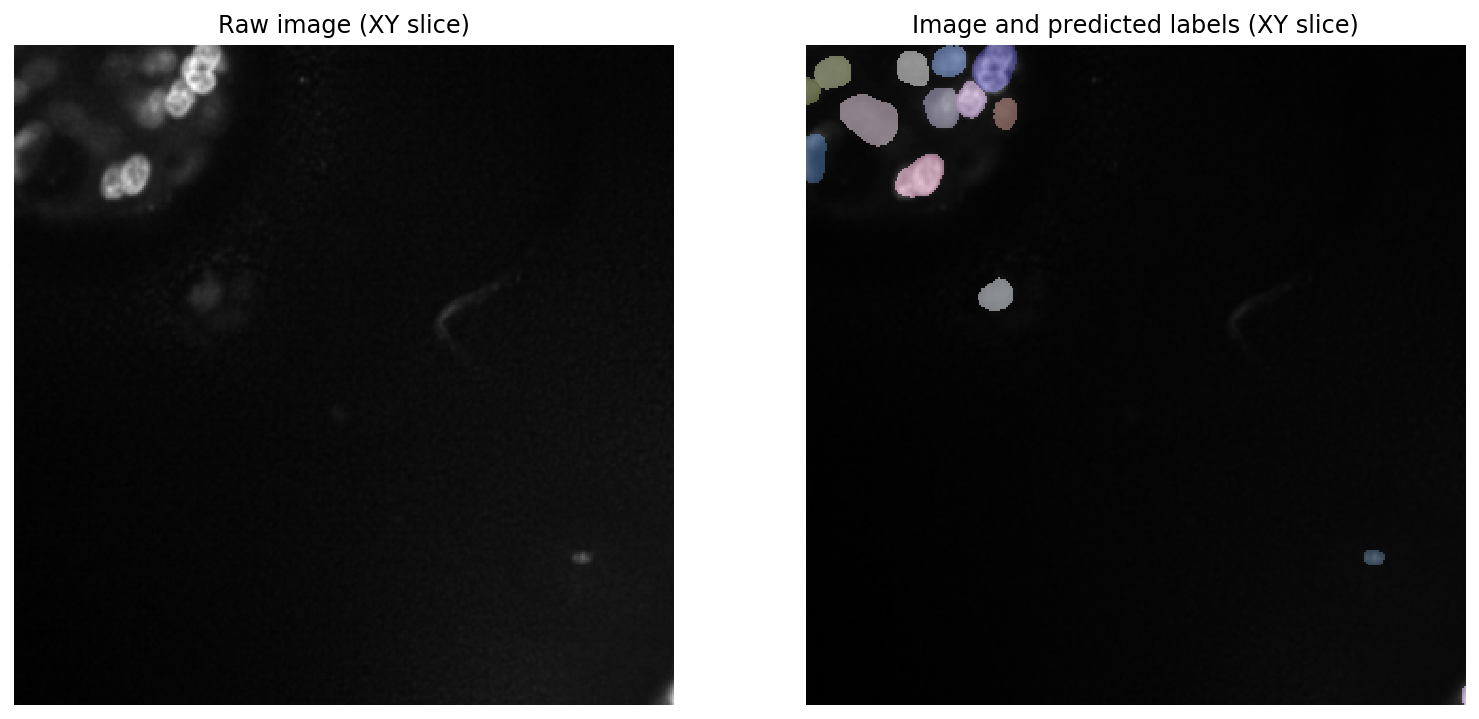

In [5]:
pixels = image.getPrimaryPixels()

print(
    "Channels: ",
    *(f"{i}: \t {c}" for i, c 
      in enumerate(image.getChannelLabels())),
    sep="\n"
)

size_z = image.getSizeZ()
print(f"Number of Z-planes: {size_z}")

def predict_plane(pixels, z, model):
    plane = pixels.getPlane(theZ=z, theC=0)
    plane = normalize(plane, 1, 99.8)
    labels, details = model.predict_instances(plane, axes="XY")
    return labels, details



    #labels, details = model.predict_instances()

# zctlist = [(z, 0, 0) for z in range(size_z)]
# stack = np.array(list(pixels.getPlanes(zctlist)))
# stack.shape
# stack = normalize(stack, 1, 99.8)






def plot_overlayed(img, labels):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 10))
    np.random.seed(6)
    lbl_cmap = random_label_cmap()

    ax0.imshow(img, cmap='gray')
    ax0.set_title('Raw image (XY slice)')
    ax0.axis('off')
    ax1.imshow(img, cmap='gray')
    ax1.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    ax1.set_title('Image and predicted labels (XY slice)')
    ax1.axis('off');

    return fig, (ax0, ax1)


crop = slice(450,800), slice(250,600)

img = pixels.getPlane(theZ=43)
lbls, details = predict_plane(pixels, 43, model)

fig, axes = plot_overlayed(img[crop], lbls.T[crop])


In [6]:
from ipywidgets import IntProgress
from IPython.display import display


In [8]:
def predict_and_register_all(image, conn, model, progress=None):
    if progress is not None:
        display(progress)
        
    pixels = image.getPrimaryPixels()
    for z in range(size_z):
        if progress is not None:
            progress.value = z
        lbls, details = predict_plane(pixels, z, model)
        n_detected = lbls.max()
        if not n_detected:
            continue
        for data in details['coord']:
            roi = register_shape_to_roi(image, data.T, conn, z=z, roi=None)
            

In [9]:
progress = IntProgress(value=0, min=0, max=size_z, step=1)
predict_and_register_all(image, conn, model, progress=progress)


IntProgress(value=0, max=70)

In [64]:
conn.isConnected()

True

In [25]:
labels.max()

32

In [10]:
roi_service = conn.getRoiService()
rois = roi_service.findByImage(image.getId(), None).rois


In [15]:
updateService = conn.getUpdateService()


In [18]:
for roi in rois:
    updateService.deleteObject(roi)

In [11]:
len(rois)

7217

In [27]:
conn.isConnected

True

In [138]:
conn.close()